# Assignment 1
## Task: Stock Prediction

Target: Develop LSTM models to predict stock prices, utilizing the past 10 days' closing prices to estimate the stock's closing price on the 5th day in the future.

### 1. Install Setup

In [1]:
!pip install yfinance
!pip install pandas_datareader
!pip install mplfinance
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler

yf.pdr_override()

### 2. Data Preparation - Shanghai Stock Exchange Index


In [3]:
# Fetch data from Yahoo Finance for the specific stock and date range
sse_data = data.get_data_yahoo('000001.SS', start="2013-01-01", end="2022-12-30")

# Display basic information about the data
sse_data.info()

# Display the first few rows of the data
sse_data.head()

# Provide descriptive statistics of the data
sse_data.describe()


[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2426 entries, 2013-01-04 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2426 non-null   float64
 1   High       2426 non-null   float64
 2   Low        2426 non-null   float64
 3   Close      2426 non-null   float64
 4   Adj Close  2426 non-null   float64
 5   Volume     2426 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.7 KB


,Open,High,Low,Close,Adj Close,Volume
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000
mean,3014.029842,3037.186045,2991.430713,3017.338248,3017.338248,239927.040396
std,527.661484,534.035913,519.041236,527.915416,527.915416,129465.679098
min,1935.515991,1959.157959,1849.652954,1950.011963,1950.011963,100.000000
25%,2762.007019,2787.020691,2734.522827,2765.485657,2765.485657,142125.000000
50%,3086.867554,3105.583008,3066.319946,3090.676392,3090.676392,208000.000000
75%,3345.864075,3370.917786,3325.507202,3350.020081,3350.020081,314250.000000
max,5174.417969,5178.190918,5103.400879,5166.350098,5166.350098,857100.000000


### 3. Data Visulization

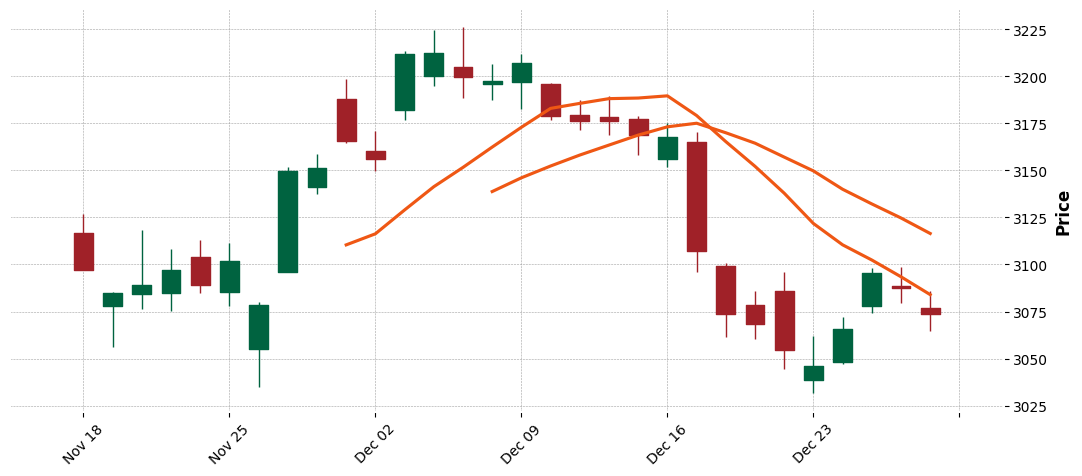

In [4]:
# Show the last 30 days
mpf.plot(sse_data[-30:],type='candle',style='charles',figratio=(12,5),mav=(10,15), volume=False)

### 4. Data Preprocessing


In [5]:
# Initialize the MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 1))

# Use Close column as predict target
df = sse_data['Close']

# Apply the scaler to the data
rdata = scaler.fit_transform(np.array(df).reshape(-1, 1))

# Determine the size for training (80% of the total data)
training_size = int(len(rdata) * 0.8)

# Split the data into training and testing periods
train_period = rdata[:training_size]
test_period = rdata[training_size:]


In [6]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(train_period, train_period, length=10, batch_size=3000)

# Create TimeseriesGenerator for testing data
test_generator = TimeseriesGenerator(test_period, test_period, length=10, batch_size=3000)

# Extract features (X) and targets (y) for training
X_train, y_train = train_generator[0]

# Extract features (X) and targets (y) for testing
X_test, y_test = test_generator[0]


### 5. Model Building


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [8]:
# Initialize the Sequential model
model = Sequential()

# Adding LSTM layers with dropout regularization
model.add(LSTM(100, return_sequences=True, input_shape=(10, 1)))
model.add(Dropout(0.15))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(100))

# Adding the output layer
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

In [9]:
# Train the model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=16,verbose=True)

Epoch 1/30
121/121 [==============================] - 14s 42ms/step - loss: 0.0066 - val_loss: 6.6930e-04
Epoch 2/30
121/121 [==============================] - 4s 30ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 3/30
121/121 [==============================] - 5s 45ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/30
121/121 [==============================] - 4s 36ms/step - loss: 0.0020 - val_loss: 5.0336e-04
Epoch 5/30
121/121 [==============================] - 4s 34ms/step - loss: 0.0017 - val_loss: 6.1373e-04
Epoch 6/30
121/121 [==============================] - 5s 43ms/step - loss: 0.0014 - val_loss: 5.7123e-04
Epoch 7/30
121/121 [==============================] - 4s 32ms/step - loss: 0.0013 - val_loss: 3.8226e-04
Epoch 8/30
121/121 [==============================] - 4s 30ms/step - loss: 0.0015 - val_loss: 5.0778e-04
Epoch 9/30
121/121 [==============================] - 4s 36ms/step - loss: 0.0011 - val_loss: 3.9649e-04
Epoch 10/30
121/121 [==============================] - 5s 41ms

### 6. Prediction


In [10]:
# Apply inverse transformation on the predictions for training data
train_predict = scaler.inverse_transform(model.predict(X_train))

# Adjust for hysteresis by slicing the array to remove the first 4 elements
train_predict = train_predict[4:]

# Apply inverse transformation on the predictions for testing data
test_predict = scaler.inverse_transform(model.predict(X_test))

# Similarly adjust for hysteresis in the test predictions
test_predict = test_predict[4:]


15/15 [==============================] - 0s 11ms/step


### 7. Plot the actual/prediction graph and calculate the accuracy of the prediction
Accuracy formula:
$$ \Sigma \left| truevalue -  predictedvalue\right| $$

Length of Train Predictions: 1926
Length of Original Data: 2426
Length of Test Predictions: 472


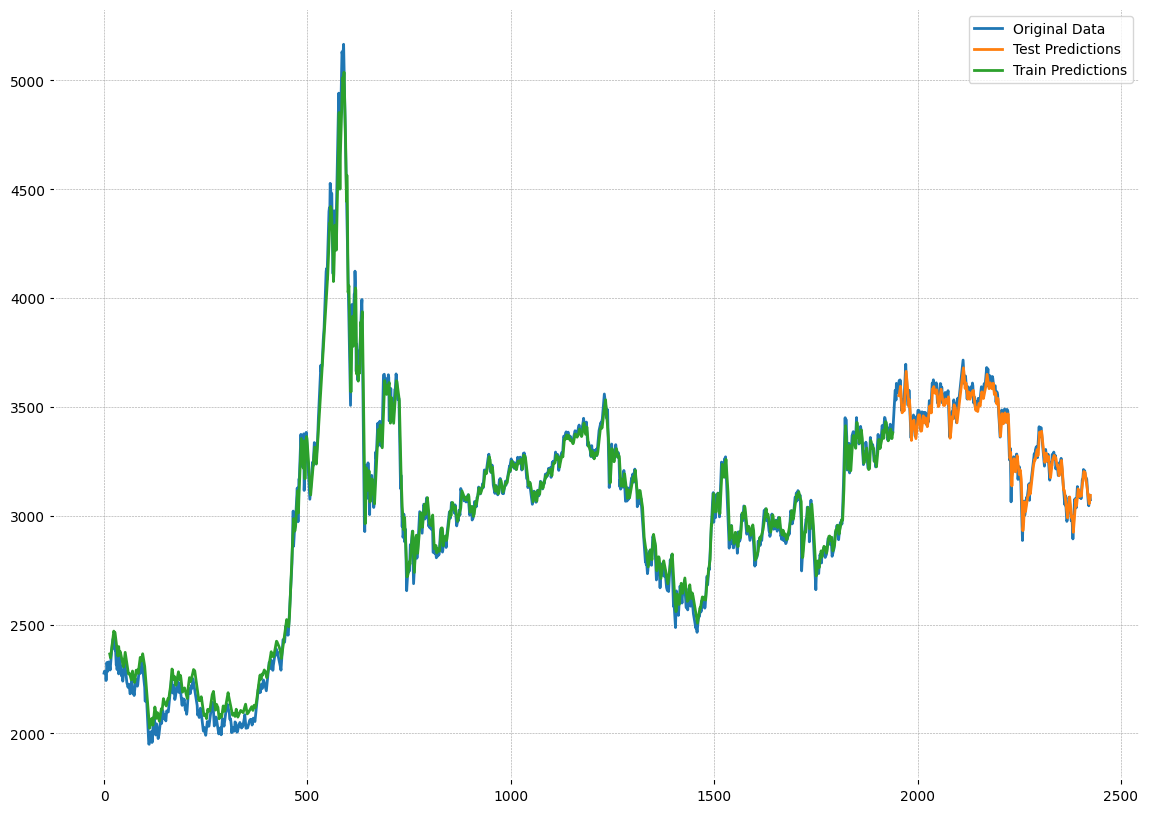

In [11]:
import numpy as np
import matplotlib.pyplot as plt

back_number = 14

# Print lengths of predictions and original data for verification
print("Length of Train Predictions:", len(train_predict))
print("Length of Original Data:", len(rdata))
print("Length of Test Predictions:", len(test_predict))

# Prepare an array for plotting training predictions
trainPredictPlot = np.empty_like(rdata)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[back_number:len(train_predict) + back_number] = train_predict

# Prepare an array for plotting testing predictions
testPredictPlot = np.empty_like(rdata)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (back_number * 2):len(rdata)] = test_predict

# Plotting the graphs
plt.figure(figsize=(14, 10))
plt.plot(scaler.inverse_transform(rdata), label='Original Data')
plt.plot(testPredictPlot, label='Test Predictions')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.legend()
plt.show()


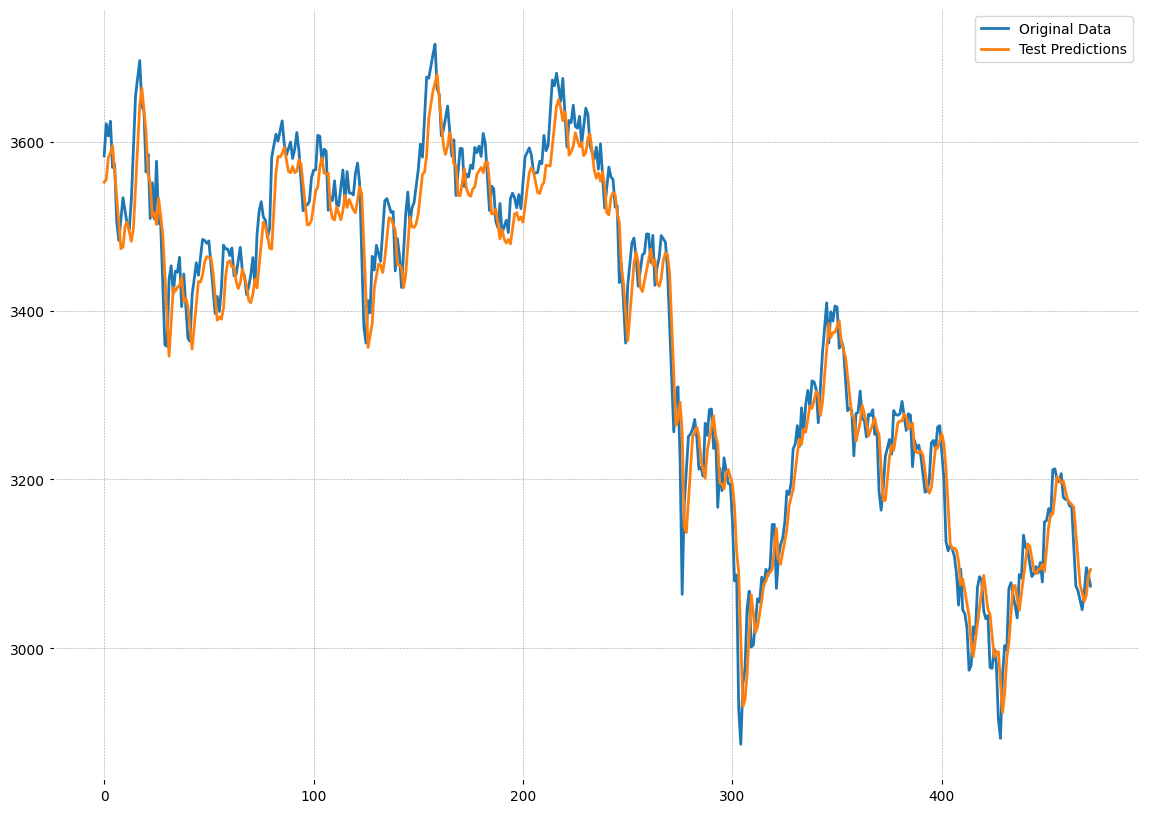

In [12]:
import matplotlib.pyplot as plt

# Setting up the plot dimensions
plt.figure(figsize=(14, 10))

# Plot the original data (after applying inverse transformation and adjusting for look-back period)
plt.plot(scaler.inverse_transform(rdata)[len(train_predict) + (back_number * 2):len(rdata)], label='Original Data')

# Plot the test predictions
plt.plot(test_predict, label='Test Predictions')

# Adding a legend for clarity
plt.legend()

# Display the plot
plt.show()


In [13]:
# Calculate the accuracy score
acc_score = abs(scaler.inverse_transform(rdata)[len(train_predict) + (back_number * 2):] - test_predict).sum()

# Print the accuracy score with formatting
print(f"The model has an accuracy score of {acc_score:.2f}.")


The model has an accuracy score of 14467.27.


### 2. Data Preparation - Ethereum price in USD


In [14]:
# Fetch data from Yahoo Finance for the specific stock and date range
eth_data = data.get_data_yahoo('ETH-USD',start="2018-01-01", end="2022-12-30")

# Display basic information about the data
eth_data.info()

# Display the first few rows of the data
eth_data.head()

# Provide descriptive statistics of the data
eth_data.describe()


[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2018-01-01 to 2022-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1824 non-null   float64
 1   High       1824 non-null   float64
 2   Low        1824 non-null   float64
 3   Close      1824 non-null   float64
 4   Adj Close  1824 non-null   float64
 5   Volume     1824 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 99.8 KB


,Open,High,Low,Close,Adj Close,Volume
count,1824.000000,1824.000000,1824.000000,1824.000000,1824.000000,1.824000e+03
mean,1147.182703,1183.735162,1105.321248,1147.197875,1147.197875,1.322629e+10
std,1201.442185,1238.299974,1158.896067,1200.920875,1200.920875,1.078124e+10
min,84.279694,85.342743,82.829887,84.308296,84.308296,9.484880e+08
25%,208.843094,213.702480,203.486496,208.824837,208.824837,5.178611e+09
50%,518.310181,531.239594,497.945312,518.147430,518.147430,1.105738e+10
75%,1803.077057,1840.343140,1733.884186,1804.206024,1804.206024,1.836588e+10
max,4810.071289,4891.704590,4718.039062,4812.087402,4812.087402,8.448291e+10


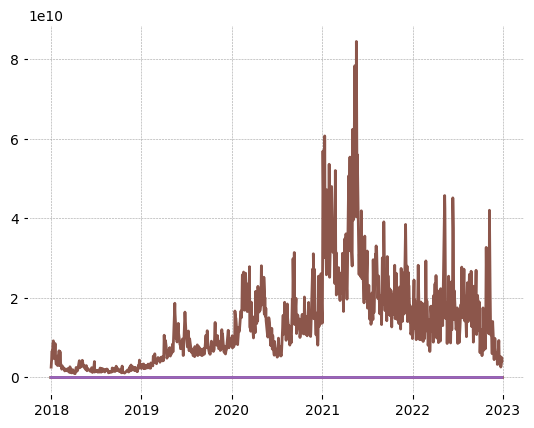

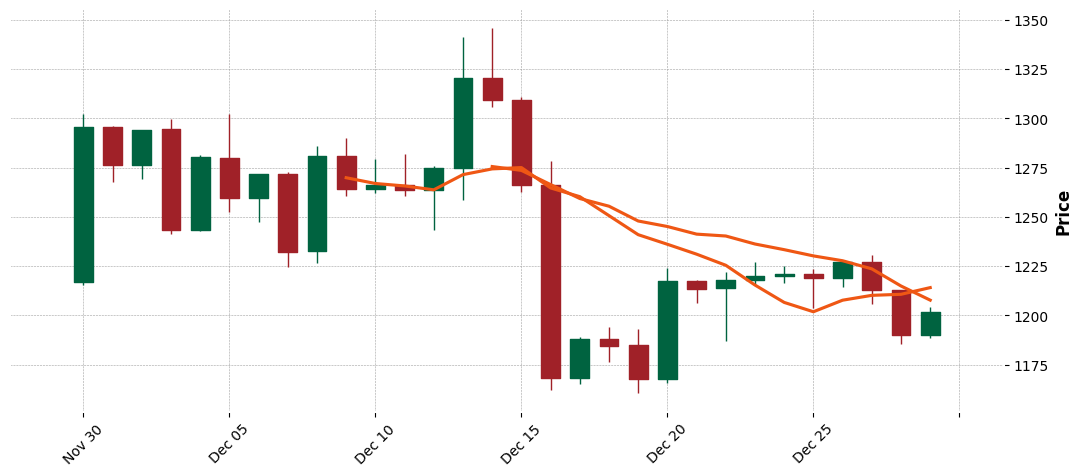

In [15]:
# Overview of the data
plt.plot(eth_data)

# The last 30 days
mpf.plot(eth_data[-30:],type='candle',style='charles',figratio=(12,5),mav=(10,15), volume=False)

### 3. Data Preprocessing

In [16]:
# Use Close column as predict target
df = eth_data['Close']

# Apply the scaler to the data
rdata = scaler.fit_transform(np.array(df).reshape(-1, 1))

# Determine the size for training (80% of the total data)
training_size = int(len(rdata) * 0.8)

# Split the data into training and testing periods
train_period = rdata[:training_size]
test_period = rdata[training_size:]

In [17]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(train_period, train_period, length=10, batch_size=3000)

# Create TimeseriesGenerator for testing data
test_generator = TimeseriesGenerator(test_period, test_period, length=10, batch_size=3000)

# Extract features (X) and targets (y) for training
X_train, y_train = list(train_generator)[0][0], list(train_generator)[0][1]

# Extract features (X) and targets (y) for testing
X_test, y_test = list(test_generator)[0][0], list(test_generator)[0][1]


### 4. Use the same LSTM model architecture

In [18]:
# Initialize the Sequential model
model = Sequential()

# Adding LSTM layers with dropout regularization
model.add(LSTM(100, return_sequences=True, input_shape=(10, 1)))
model.add(Dropout(0.15))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(100))

# Adding the output layer
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model's architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 100)           40800     
                                                                 
 dropout_3 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_4 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_5 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)              

In [19]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=16,verbose=True)

Epoch 1/30
91/91 [==============================] - 13s 56ms/step - loss: 0.0104 - val_loss: 0.0091
Epoch 2/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 3/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 4/30
91/91 [==============================] - 4s 39ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 5/30
91/91 [==============================] - 4s 42ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/30
91/91 [==============================] - 3s 30ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 7/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 8/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0016 - val_loss: 0.0116
Epoch 9/30
91/91 [==============================] - 4s 47ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 10/30
91/91 [==============================] - 3s 35ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 11


### 5. Prediction

In [20]:
# Apply inverse transformation on the predictions for training data
train_predict = scaler.inverse_transform(model.predict(X_train))

# Adjust for hysteresis by slicing the array to remove the first 4 elements
train_predict = train_predict[4:]

# Apply inverse transformation on the predictions for testing data
test_predict = scaler.inverse_transform(model.predict(X_test))

# Similarly adjust for hysteresis in the test predictions
test_predict = test_predict[4:]

12/12 [==============================] - 0s 12ms/step



### Plot the actual/prediction graph and calculate the accuracy of the prediction

- Accuracy formula:
$$ \Sigma \left| truevalue -  predictedvalue\right| $$

Length of Train Predictions: 1445
Length of Original Data: 1824
Length of Test Predictions: 351


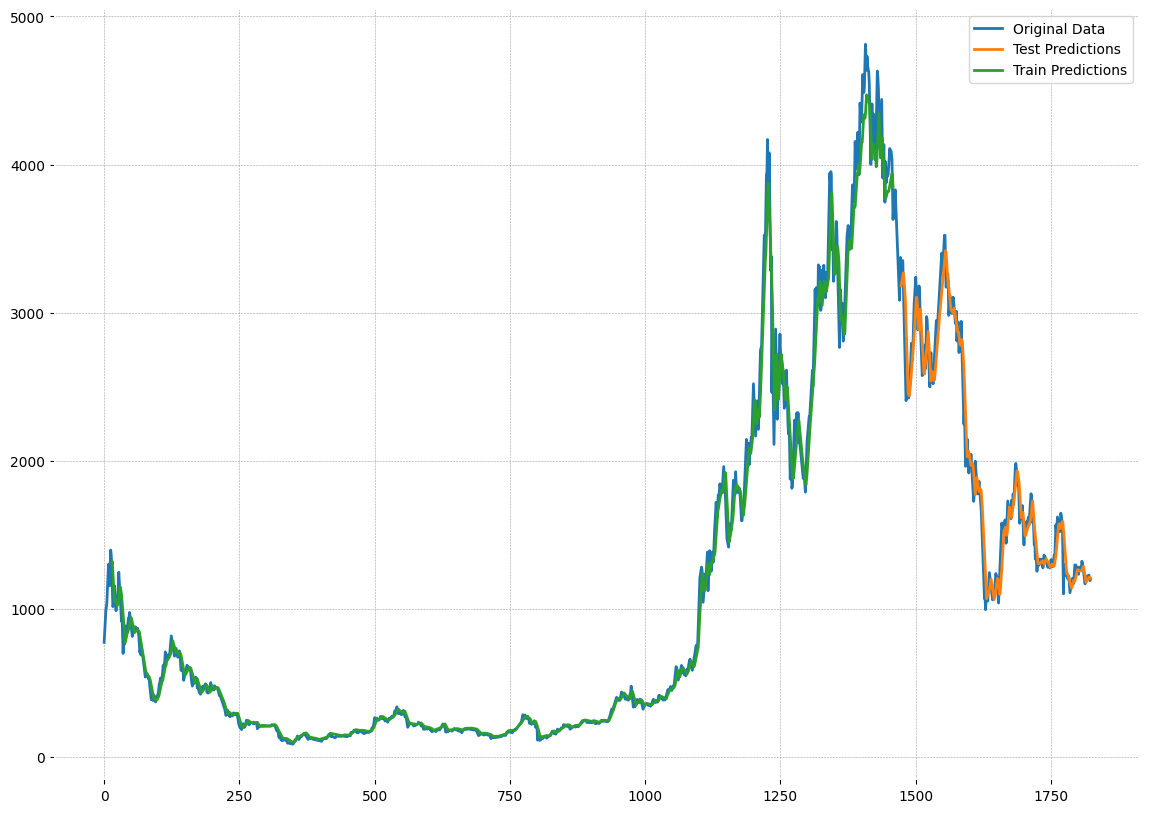

In [21]:
import numpy as np
import matplotlib.pyplot as plt

back_number = 14

# Print lengths of predictions and original data for verification
print("Length of Train Predictions:", len(train_predict))
print("Length of Original Data:", len(rdata))
print("Length of Test Predictions:", len(test_predict))

# Prepare an array for plotting training predictions
trainPredictPlot = np.empty_like(rdata)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[back_number:len(train_predict) + back_number] = train_predict

# Prepare an array for plotting testing predictions
testPredictPlot = np.empty_like(rdata)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (back_number * 2):len(rdata)] = test_predict

# Plotting the graphs
plt.figure(figsize=(14, 10))
plt.plot(scaler.inverse_transform(rdata), label='Original Data')
plt.plot(testPredictPlot, label='Test Predictions')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.legend()
plt.show()

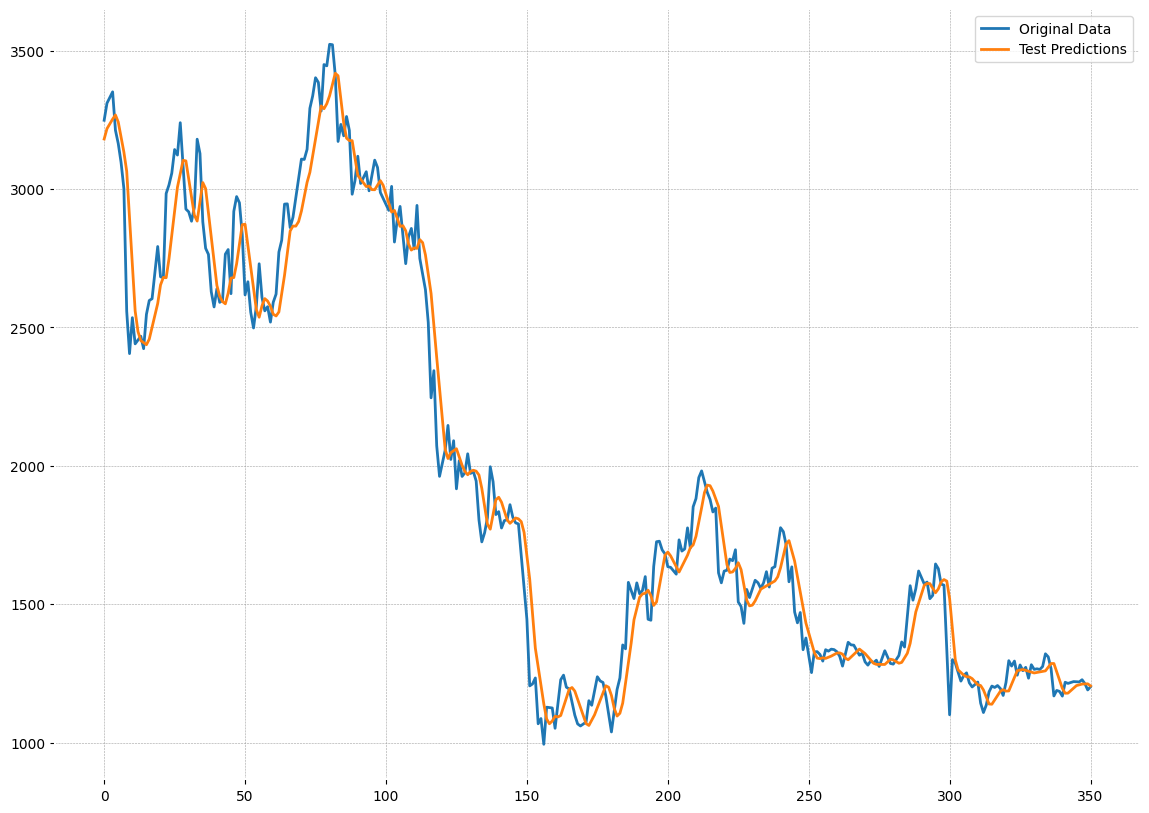

In [22]:
import matplotlib.pyplot as plt

# Setting up the plot dimensions
plt.figure(figsize=(14, 10))

# Plot the original data (after applying inverse transformation and adjusting for look-back period)
plt.plot(scaler.inverse_transform(rdata)[len(train_predict) + (back_number * 2):len(rdata)], label='Original Data')

# Plot the test predictions
plt.plot(test_predict, label='Test Predictions')

# Adding a legend for clarity
plt.legend()

# Display the plot
plt.show()

In [23]:
# Calculate the accuracy score
acc_score = abs(scaler.inverse_transform(rdata)[len(train_predict) + (back_number * 2):] - test_predict).sum()

# Print the accuracy score with formatting
print(f"The model has an accuracy score of {acc_score:.2f}.")


The model has an accuracy score of 30173.84.


An artificial time series with > 1000 data points generated by you (e.g.,
you may generate a sine curve and for every data point, +/- some
random values) for training/testing

### 2. Data Preparation - An artificial time series

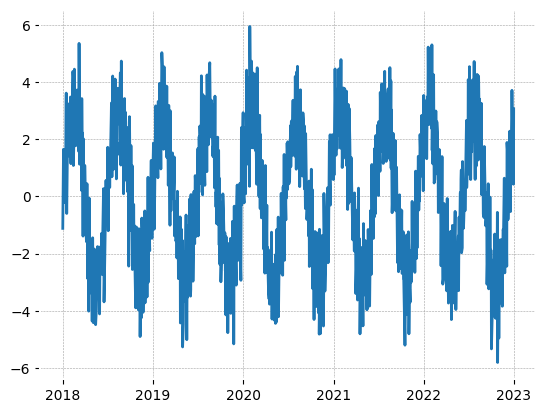

In [24]:
import pandas as pd
import numpy as np

# Create a date range index
dates_index = pd.date_range(start='2018-01-01', end='2022-12-31', freq='D')

# Generate sine wave data
sine_wave = np.sin(2 * np.pi * np.arange(len(dates_index)) / 180) * 3

# Generate random noise
noise = np.random.standard_normal(size=len(dates_index))

# Combine sine wave and noise to create artificial series
artificial_series = sine_wave + noise

# Create DataFrame with the artificial series
df = pd.DataFrame({'Artificial Series': artificial_series}, index=dates_index)

# Plot the dataframe
plt.plot(df)

In [25]:
# Apply the scaler to the data
rdata = scaler.fit_transform(np.array(df).reshape(-1, 1))

# Determine the size for training (80% of the total data)
training_size = int(len(rdata) * 0.8)

# Split the data into training and testing periods
train_period = rdata[:training_size]
test_period = rdata[training_size:]

In [26]:
# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(train_period, train_period, length=10, batch_size=3000)

# Create TimeseriesGenerator for testing data
test_generator = TimeseriesGenerator(test_period, test_period, length=10, batch_size=3000)

# Extract features (X) and targets (y) for training
X_train, y_train = list(train_generator)[0][0], list(train_generator)[0][1]

# Extract features (X) and targets (y) for testing
X_test, y_test = list(test_generator)[0][0], list(test_generator)[0][1]


### 3. Use the same LSTM model architecture

In [27]:
# Initialize the Sequential model
model = Sequential()

# Adding LSTM layers with dropout regularization
model.add(LSTM(100, return_sequences=True, input_shape=(10, 1)))
model.add(Dropout(0.15))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(100))

# Adding the output layer
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Display the model's architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 100)           40800     
                                                                 
 dropout_6 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_7 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_10 (LSTM)              (None, 10, 100)           80400     
                                                                 
 dropout_8 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100)              

In [28]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=16,verbose=True)

Epoch 1/30
91/91 [==============================] - 13s 60ms/step - loss: 0.0254 - val_loss: 0.0111
Epoch 2/30
91/91 [==============================] - 3s 36ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 3/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 4/30
91/91 [==============================] - 3s 36ms/step - loss: 0.0118 - val_loss: 0.0135
Epoch 5/30
91/91 [==============================] - 3s 37ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 6/30
91/91 [==============================] - 4s 45ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 7/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 8/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0099 - val_loss: 0.0106
Epoch 9/30
91/91 [==============================] - 3s 31ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 10/30
91/91 [==============================] - 4s 45ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 11


### 4. Prediction

In [29]:
# Apply inverse transformation on the predictions for training data
train_predict = scaler.inverse_transform(model.predict(X_train))

# Adjust for hysteresis by slicing the array to remove the first 4 elements
train_predict = train_predict[4:]

# Apply inverse transformation on the predictions for testing data
test_predict = scaler.inverse_transform(model.predict(X_test))

# Similarly adjust for hysteresis in the test predictions
test_predict = test_predict[4:]

12/12 [==============================] - 0s 15ms/step



### 5. Plot the actual/prediction graph and calculate the accuracy of the prediction

Accuracy formula:
$$ \Sigma \left| truevalue -  predictedvalue\right| $$

Length of Train Predictions: 1446
Length of Original Data: 1826
Length of Test Predictions: 352


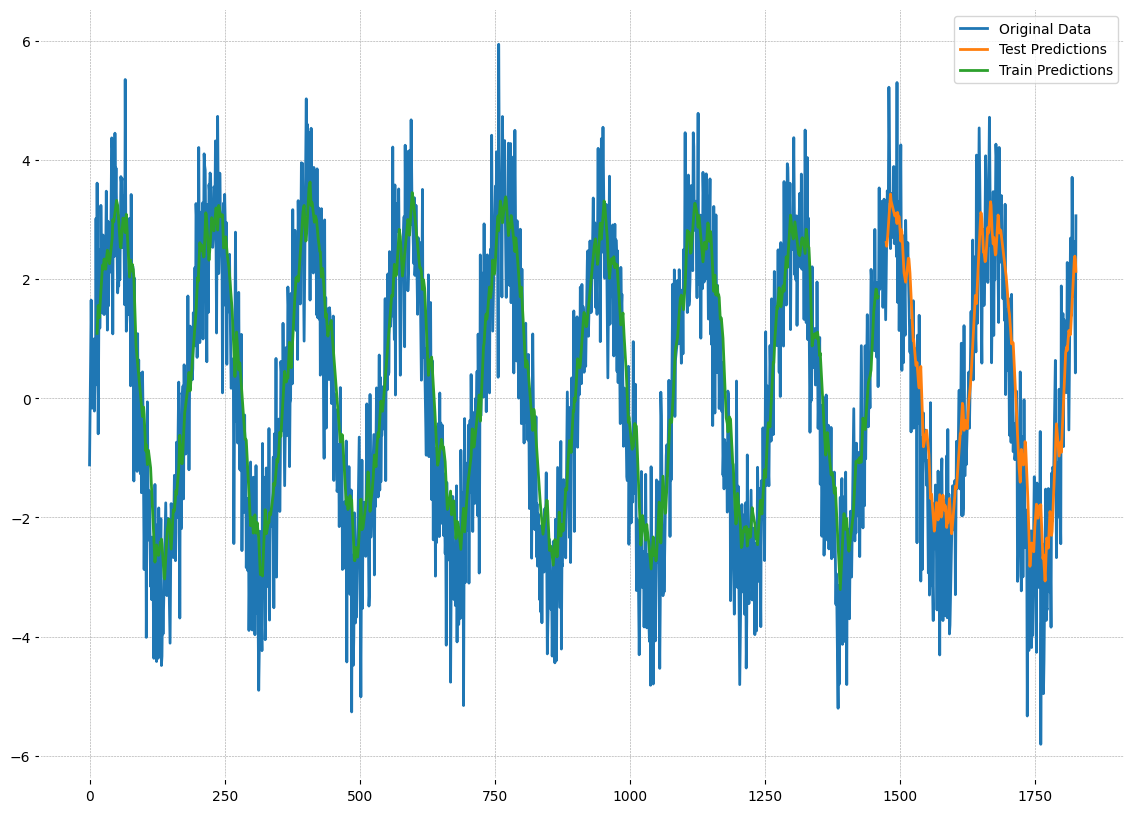

In [30]:
import numpy as np
import matplotlib.pyplot as plt

back_number = 14

# Print lengths of predictions and original data for verification
print("Length of Train Predictions:", len(train_predict))
print("Length of Original Data:", len(rdata))
print("Length of Test Predictions:", len(test_predict))

# Prepare an array for plotting training predictions
trainPredictPlot = np.empty_like(rdata)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[back_number:len(train_predict) + back_number] = train_predict

# Prepare an array for plotting testing predictions
testPredictPlot = np.empty_like(rdata)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (back_number * 2):len(rdata)] = test_predict

# Plotting the graphs
plt.figure(figsize=(14, 10))
plt.plot(scaler.inverse_transform(rdata), label='Original Data')
plt.plot(testPredictPlot, label='Test Predictions')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.legend()
plt.show()

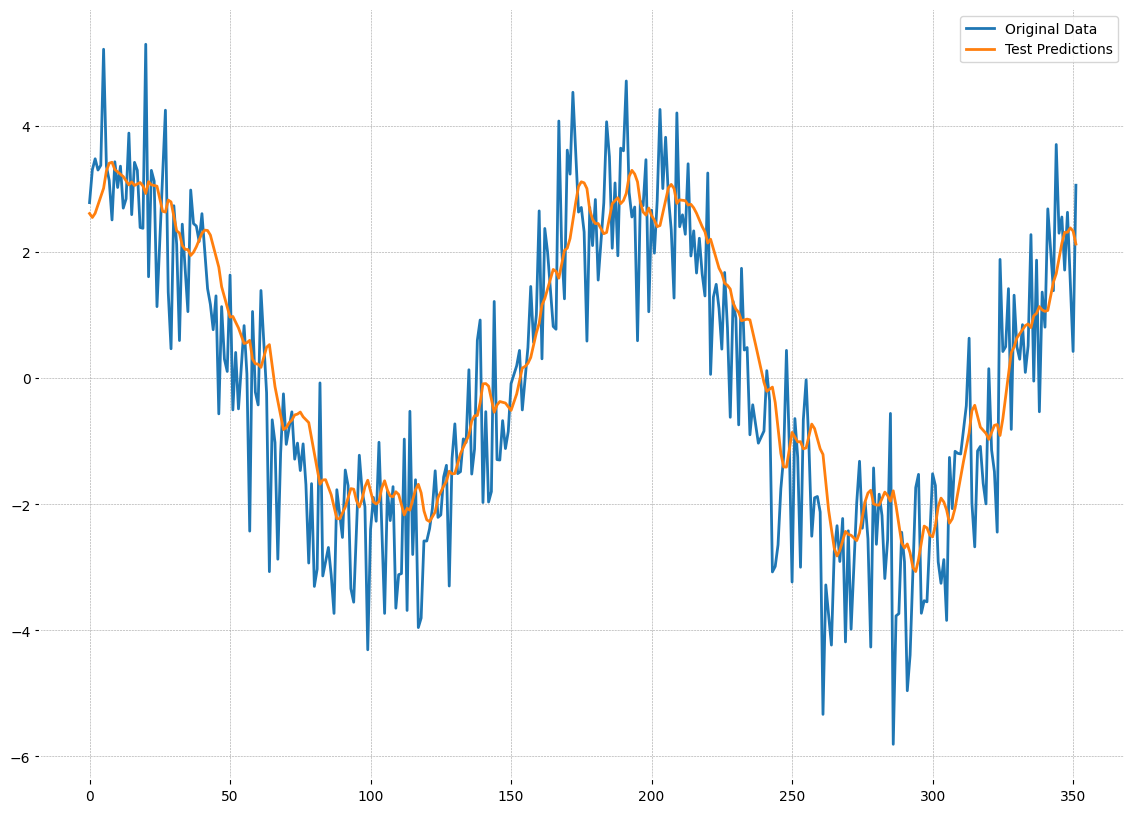

In [31]:
import matplotlib.pyplot as plt

# Setting up the plot dimensions
plt.figure(figsize=(14, 10))

# Plot the original data (after applying inverse transformation and adjusting for look-back period)
plt.plot(scaler.inverse_transform(rdata)[len(train_predict) + (back_number * 2):len(rdata)], label='Original Data')

# Plot the test predictions
plt.plot(test_predict, label='Test Predictions')

# Adding a legend for clarity
plt.legend()

# Display the plot
plt.show()

In [32]:
# Calculate the accuracy score
acc_score = abs(scaler.inverse_transform(rdata)[len(train_predict) + (back_number * 2):] - test_predict).sum()

# Print the accuracy score with formatting
print(f"The model has an accuracy score of {acc_score:.2f}.")


The model has an accuracy score of 316.75.


# b. Reinforcement Learning (50%)
In Lecture 4, you were introduced to a program that plays the OpenAI Gym's Cart
Pole game by taking random actions for every step. This assignment challenges you to
transfer this program to OpenAI Gym's Pong ('PongDeterministic-v4') game and
improve it to win against the AI opponent. In addition to submitting the program, you
must also provide a rendered one-minute video of the trained agent playing the
game (accelerate it if needed, mark the timestamp of the highest score in a
separate short report file) and the rewards evolving plot in each training episode.
You will receive a minimum of 70% if the sample training trajectory shows that the
agent can beat the AI opponent at least once, meaning the agent receives a reward of
21. Besides, you will
i. Earn an additional 20% if your solution's performance (i.e., the total
number of training episodes, fewer is better) ranks in the top 25% of
all submitted answers
ii. Earn another 10% if it ranks in the to